In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxidemandfarepredictiondataset/yellow_tripdata_2016-01.csv
/kaggle/input/taxidemandfarepredictiondataset/yellow_tripdata_2016-03.csv
/kaggle/input/taxidemandfarepredictiondataset/yellow_tripdata_2016-02.csv
/kaggle/input/taxidemandfarepredictiondataset/yellow_tripdata_2015-03.csv
/kaggle/input/taxidemandfarepredictiondataset/yellow_tripdata_2015-01.csv
/kaggle/input/taxidemandfarepredictiondataset/yellow_tripdata_2015-02.csv


Task : Perform hyper-parameter tuning for Regression models. 

       2a. Linear Regression: Grid Search 
       
       2b. Random Forest: Random Search  
       
       2c. Xgboost: Random Search

The problem statement provides pickup details of customers using cab aggregator. It provides low level details of every pickup location, time and other further details w.r.t ride.

Task at hand is to determine the demand. Demand can be termed as the number of pickups made by taxi aggregator at a specific time. This demand can be converted into percentage by dividing with maximum number of pickups that can happen at any hour. This is precisely what we have done.

The location data is converted to location clusters using clustering algorithm. The datetime of pickup is transformed and we extract time as a useful feature from pickup datetime. With location cluster & pickup hour, we create our models. 

After validating multiple regression models such as LR, RF, XGBoost, we decided on using XGBoost after loosing all the not so important features.

An inference function is also written at the end that will be useful when we try to deploy this as a model for a POC given we save the XGboost and Kmeans and use those in inferencing.

In [ ]:
df = pd.read_csv("/kaggle/input/taxidemandfarepredictiondataset/yellow_tripdata_2015-02.csv")
df = df.sample(frac=0.005)

In [4]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
2621932,1,2015-02-11 08:51:11,2015-02-11 09:11:38,1,2.70,-73.958549,40.769039,1,N,-73.985420,40.755318,1,14.0,0.0,0.5,1.5,0.0,0.3,16.3
10835927,2,2015-02-21 18:09:15,2015-02-21 18:12:31,1,0.53,-73.968376,40.754578,1,N,-73.963959,40.756882,1,4.5,0.0,0.5,1.5,0.0,0.3,6.8
671259,2,2015-02-07 23:34:00,2015-02-07 23:45:02,2,3.38,-73.972610,40.793587,1,N,-73.996597,40.765121,2,12.5,0.5,0.5,0.0,0.0,0.3,13.8
11498570,2,2015-02-22 14:33:23,2015-02-22 14:40:30,1,1.03,-73.991257,40.749710,1,N,-73.979355,40.753212,2,6.5,0.0,0.5,0.0,0.0,0.3,7.3
6184665,1,2015-02-14 23:44:02,2015-02-14 23:57:55,1,3.40,-73.954971,40.773441,1,N,-73.980255,40.732281,2,12.5,0.5,0.5,0.0,0.0,0.3,13.8


In [5]:
print(df.shape, df.columns)

(62253, 19) Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [6]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [7]:
df['RateCodeID'].value_counts()
df['payment_type'].value_counts()
df['store_and_fwd_flag'].value_counts()

N    61692
Y      561
Name: store_and_fwd_flag, dtype: int64

In [8]:
df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']] = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].apply(pd.to_datetime)
df[['VendorID','RateCodeID','payment_type', 'store_and_fwd_flag' ]] = df[['VendorID','RateCodeID','payment_type', 'store_and_fwd_flag' ]].astype(str)

In [9]:
df.describe(include='all').T

# std deviation on trip distance along with max is really high. lets explore this further
# last in tpep_dropoff_datetime looks impossible realistically. lets explore this further
# passenger_count max is an outlier
# -ve values in min of amount columns shows the cab service works on credit as well. Let's see how many such entries are there.
# Overall these above ideas will help us to remove outliers and overall rows from dataset

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
VendorID,62253,2,2,32598,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpep_pickup_datetime,62253,61293,2015-02-28 13:33:45,3,2015-02-01 00:00:16,2015-02-28 23:59:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tpep_dropoff_datetime,62253,61281,2015-02-26 00:00:00,3,2015-02-01 00:05:18,2015-03-01 20:03:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
passenger_count,62253.0,NaN,NaN,NaN,NaT,NaT,1.670779,1.334606,0.0,1.0,1.0,2.0,6.0
trip_distance,62253.0,NaN,NaN,NaN,NaT,NaT,33.351203,6766.640529,0.0,1.0,1.7,3.09,1672819.9
pickup_longitude,62253.0,NaN,NaN,NaN,NaT,NaT,-72.546972,10.187553,-121.914879,-73.991951,-73.981796,-73.966644,0.0
pickup_latitude,62253.0,NaN,NaN,NaN,NaT,NaT,39.963522,5.610025,0.0,40.735287,40.752876,40.767509,41.060158
RateCodeID,62253,7,1,60851,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_and_fwd_flag,62253,2,N,61692,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_longitude,62253.0,NaN,NaN,NaN,NaT,NaT,-72.597397,10.007382,-121.915237,-73.991287,-73.979729,-73.962151,0.0


In [10]:
df = df.drop_duplicates(keep='last')
df.shape

(62253, 19)

In [11]:
df.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
pickup_longitude         0
pickup_latitude          0
RateCodeID               0
store_and_fwd_flag       0
dropoff_longitude        0
dropoff_latitude         0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

In [12]:
# remove pickup and drops outside newyork city limits

df.drop(df.index[
        ~((df['pickup_latitude'].between(40.496115395170364, 40.91553277700258)) &
          (df['pickup_longitude'].between(-74.25559136315209, -73.7000090639354))) 
], inplace=True)

df.drop(df.index[
        ~((df['dropoff_latitude'].between(40.496115395170364, 40.91553277700258)) &
          (df['dropoff_longitude'].between(-74.25559136315209, -73.7000090639354))) 
], inplace=True)
df.shape

(60896, 19)

In [13]:
df = df.reset_index()

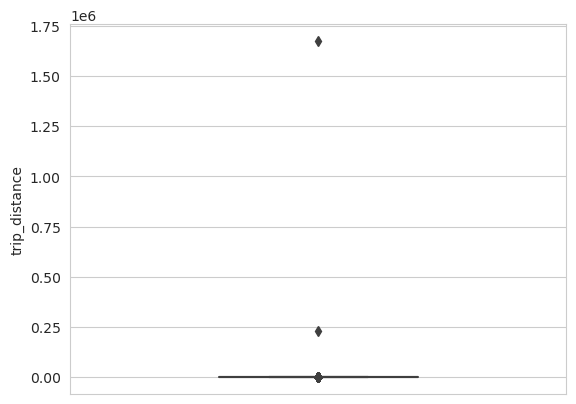

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt

def bplot(df, a):
    sns.set_style('whitegrid')
    sns.boxplot(y=a, data=df, width=0.4)
    plt.show()

bplot(df, 'trip_distance')

In [15]:
def computer_remove_outliers(df, x, remove_outlier=1):
    q1 = df[x].quantile(0.25)
    q3 = df[x].quantile(0.75)
    iqr = q3-q1
    ll = q1 - 1.5*(iqr)
    ul = q3 + 1.5*(iqr)
    print('lower limit of dist is {} and upper limit of dist is {}'.format(ll, ul))

    # remove all negative distances and distances greater than ul
    if remove_outlier==1:
        df = df[(df[x]>ll) & (df[x]<ul)]
        df.shape
        return df

df = computer_remove_outliers(df, 'trip_distance')
df = df[df['trip_distance'] > 0]

lower limit of dist is -2.1500000000000004 and upper limit of dist is 6.25


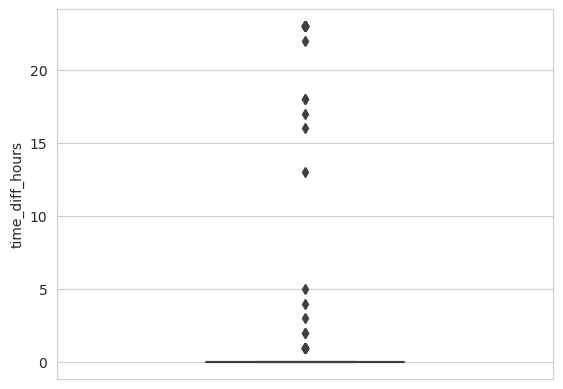

In [16]:
# identify outliers in date columns - trips more than n hours could be outliers.
df['time_diff_hours'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).astype('timedelta64[h]')
df['time_diff_hours'] = df['time_diff_hours'].astype(int)
bplot(df, 'time_diff_hours')

(df['time_diff_hours'].value_counts().sort_values(ascending=False))
# based on above statement output, time diff greater than 1 can be neglected
df = df[df["time_diff_hours"] < 2]
df.shape

# remove cancelled rides
df['time_diff_min'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).astype('timedelta64[m]')
df[df['time_diff_min']==0]
df = df[df["time_diff_min"] > 0]  


In [17]:
# remove uncommon passenger counts
df["passenger_count"].value_counts(normalize=True).sort_values(ascending=False) * 100
df = df[(df["passenger_count"] <=2) & (df["passenger_count"] >0)]
df.shape

(46297, 22)

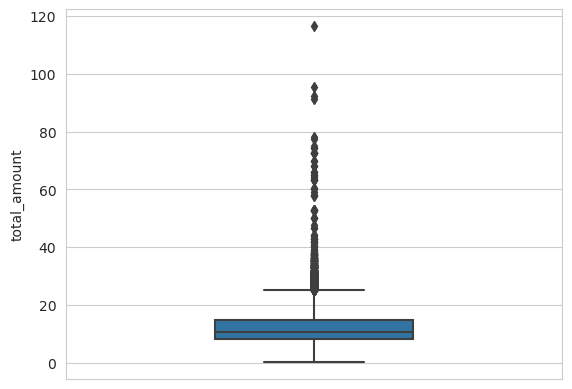

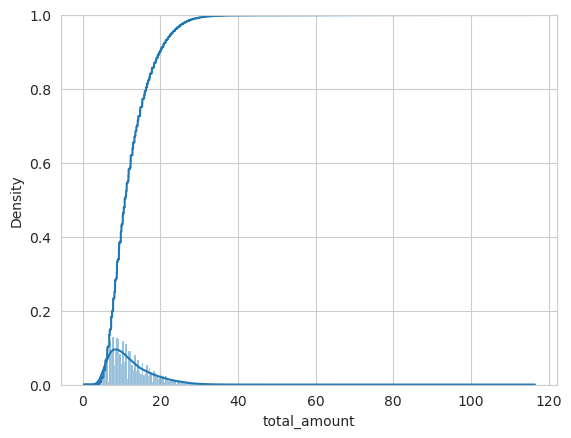

lower limit of dist is -2.0999999999999996 and upper limit of dist is 25.259999999999998


(46290, 22)

In [18]:
df = df[(df['total_amount'] > 0) & (df['total_amount'] < 500)]
df.shape

df = df[df['extra'] >= 0]
df.shape

bplot(df, 'total_amount')

sns.set_style('whitegrid')
sns.histplot(kde=True, data=df['total_amount'], stat='density')
sns.ecdfplot(df['total_amount'])
plt.show()

computer_remove_outliers(df, 'total_amount', 0)

# based on above analysis, we can easily remove total amount > 200 even though the max from box plot came out as $25
df = df[df['total_amount'] < 200]
df.shape

In [19]:
df_location = df[['pickup_latitude', 'pickup_longitude']]

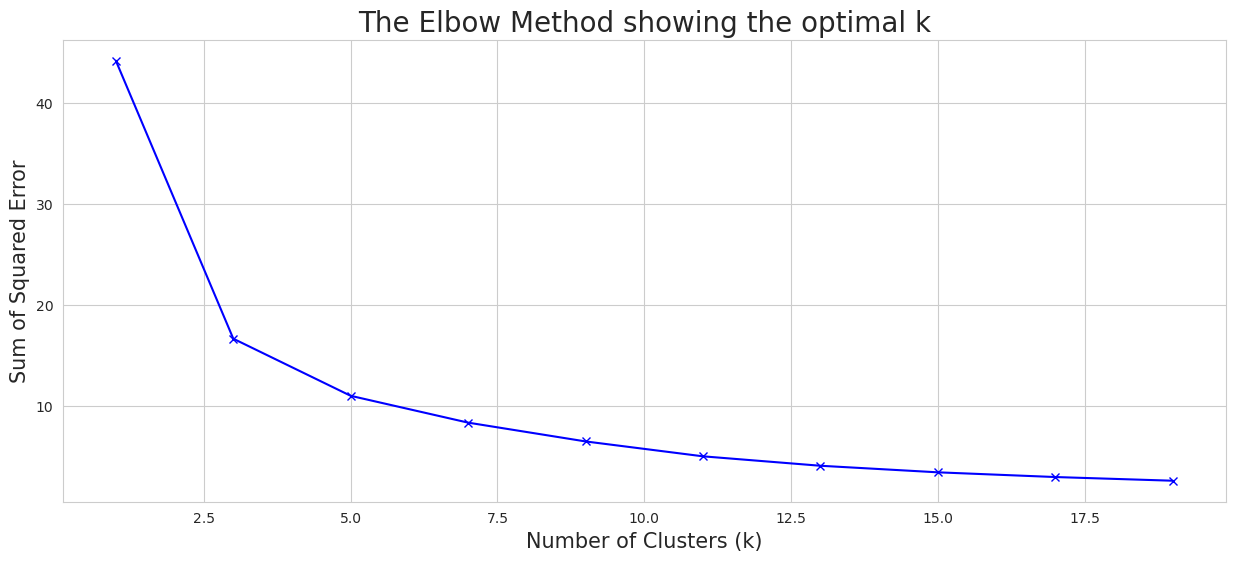

In [21]:
from sklearn.cluster import KMeans

# # Elbox plot to find k in k means
# from sklearn.cluster import KMeans

sse = []
K = range(1,20, 2)
for k in K:
     kmeanModel = KMeans(n_clusters=k)
     kmeanModel.fit(df_location)
     sse.append(kmeanModel.inertia_)

plt.figure(figsize=(15,6))
plt.plot(K, sse, 'bx-')
plt.xlabel('Number of Clusters (k)', fontsize = 15)
plt.ylabel('Sum of Squared Error', fontsize = 15)
plt.title('The Elbow Method showing the optimal k', fontsize = 20)
plt.show()

In [22]:
df_location.dtypes

pickup_latitude     float64
pickup_longitude    float64
dtype: object

In [23]:
# # from elbow plot, we see that SSE reduces slowly after k value __ . Still, lets try silhoutte score for many k values.
# from sklearn.metrics import silhouette_score

# print("Clusters\tSilhoutte Score\n")
# for n_cluster in range(5, 15):
#     kmeans = KMeans(n_clusters=n_cluster).fit(df_location)
#     label = kmeans.labels_
#     sil_coeff = silhouette_score(df_location, label, metric='euclidean')
#     print("k = {} \t--> \t{}".format(n_cluster, sil_coeff))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


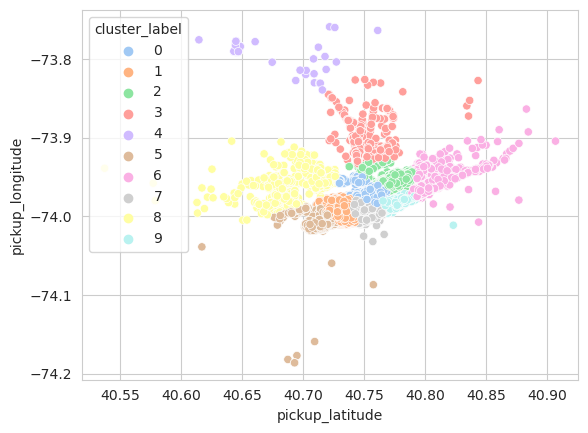

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 10) 
df_location['cluster_label'] = kmeans.fit_predict(df_location)  # df_location has lat and long in a DF.
df_location['cluster_label'].value_counts().sort_values(ascending=False)

sns.set_style('whitegrid')
sns.scatterplot(x='pickup_latitude', y = 'pickup_longitude', data=(df_location),hue='cluster_label', palette='pastel')
plt.show()

In [25]:
df_with_loc_clusters = pd.merge(df_location, df, on=['pickup_latitude', 'pickup_longitude'])

In [26]:
df_with_loc_clusters['pickup_hour'] = df_with_loc_clusters["tpep_pickup_datetime"].dt.hour
df_with_loc_clusters['pickup_dayofweek'] = df_with_loc_clusters["tpep_pickup_datetime"].dt.dayofweek

In [27]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df_with_loc_clusters.head()

,pickup_latitude,pickup_longitude,cluster_label,index,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,time_diff_hours,time_diff_min,pickup_hour,pickup_dayofweek
0,40.769039,-73.958549,2,2621932,1,2015-02-11 08:51:11,2015-02-11 09:11:38,1,2.70,1,N,-73.985420,40.755318,1,14.0,0.0,0.5,1.5,0.0,0.3,16.3,0,20.0,8,2
1,40.754578,-73.968376,0,10835927,2,2015-02-21 18:09:15,2015-02-21 18:12:31,1,0.53,1,N,-73.963959,40.756882,1,4.5,0.0,0.5,1.5,0.0,0.3,6.8,0,3.0,18,5
2,40.793587,-73.972610,6,671259,2,2015-02-07 23:34:00,2015-02-07 23:45:02,2,3.38,1,N,-73.996597,40.765121,2,12.5,0.5,0.5,0.0,0.0,0.3,13.8,0,11.0,23,5
3,40.749710,-73.991257,7,11498570,2,2015-02-22 14:33:23,2015-02-22 14:40:30,1,1.03,1,N,-73.979355,40.753212,2,6.5,0.0,0.5,0.0,0.0,0.3,7.3,0,7.0,14,6
4,40.773441,-73.954971,2,6184665,1,2015-02-14 23:44:02,2015-02-14 23:57:55,1,3.40,1,N,-73.980255,40.732281,2,12.5,0.5,0.5,0.0,0.0,0.3,13.8,0,13.0,23,5


In [28]:
df_model = df_with_loc_clusters.groupby(['pickup_dayofweek','pickup_hour', 'cluster_label']).size().reset_index()
df_model = df_model.rename(columns={0:'demand'})
df_model['demand'] = df_model['demand']/df_model['demand'].max()
df_model['demand'] = round((df_model['demand'] * 100), 2)
df_model.head()
df_model.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
pickup_dayofweek,1522.0,3.007884,2.010476,0.00,1.00,3.00,5.00,6.0
pickup_hour,1522.0,11.559790,6.936884,0.00,6.00,12.00,18.00,23.0
cluster_label,1522.0,4.530880,2.989907,0.00,2.00,5.00,7.00,9.0
demand,1522.0,20.199731,19.476049,0.66,3.31,13.25,33.77,100.0


In [29]:
from sklearn.model_selection import train_test_split

X = df_model.drop(["demand"],axis=1)
y = df_model[['demand']]
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=100)

from sklearn.preprocessing import OneHotEncoder
cat_columns = ['pickup_dayofweek', 'pickup_hour', 'cluster_label']
enc = OneHotEncoder()
enc.fit(X_train[cat_columns])
X_train_encoded = enc.transform(X_train[cat_columns]).toarray()
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=enc.get_feature_names(cat_columns))
X_train_model = pd.concat([X_train.reset_index(), X_train_encoded_df], axis=1).drop(['index'], axis=1)

X_test_encoded = enc.transform(X_test[cat_columns]).toarray()
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=enc.get_feature_names(cat_columns))
X_test_model = pd.concat([X_test.reset_index(), X_test_encoded_df], axis=1).drop(['index'], axis=1)

X_train_model = X_train_model.drop(cat_columns, axis=1)
X_test_model = X_test_model.drop(cat_columns, axis=1)

X_train_model[X_train_model.columns] = X_train_model[X_train_model.columns].astype(int)
X_test_model[X_test_model.columns] = X_test_model[X_test_model.columns].astype(int)

y_train_model = y_train.reset_index().drop(['index'], axis=1)
y_test_model = y_test.reset_index().drop(['index'], axis=1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

y_train_model = y_train_model['demand']
y_test_model = y_test_model['demand']

models = []
models.append(('LinearRegression',LinearRegression()))
models.append(('RandomForest' ,RandomForestRegressor()))  # RF is bound to overfit and we will have to tune it later.
models.append(('xgboost' ,XGBRegressor()))  # RF is bound to overfit and we will have to tune it later.


for name , model in models :
    model.fit(X_train_model , y_train_model)
    
    prediction = model.predict(X_test_model)
    
    mse = mean_squared_error(prediction, y_test_model)
    r2 = model.score(X_test_model,y_test_model)
    print('{}: MSE is {} and R2 is {}'.format(name, round(mse,2), round(r2,2)))
    print('\n')
    
    
# Base model selected is XGboost. RandomForest is also close. So, lets expand further in these 2 algorithms.

LinearRegression: MSE is 95.2 and R2 is 0.75


RandomForest: MSE is 41.29 and R2 is 0.89


xgboost: MSE is 39.8 and R2 is 0.89




In [31]:
# Hpyerparameter tuning for XGBoost algorithm

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

xgb_model = XGBRegressor(eval_metric=mean_squared_error)
param_dist = {"max_depth": [2,5,7],  # 5
              "n_estimators": [50, 70, 100, 300, 500, 1000],  # 100
              "learning_rate" : [0.01,0.05, 0.1,0.3, 0.5]}  # 0.1
grid_search = GridSearchCV(xgb_model, param_grid=param_dist, cv = 3, 
                                   verbose=1, n_jobs=-1)
grid_search.fit(X_train_model, y_train_model.ravel())
print(grid_search.best_estimator_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7ad744cd3440>,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)


In [32]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Define models
models = []
models.append(('LinearRegression', LinearRegression()))
models.append(('SVR', SVR()))
models.append(('SGD', SGDRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('RandomForest', RandomForestRegressor()))  # RF is bound to overfit and we will have to tune it later.
models.append(('XGBoost', XGBRegressor()))
models.append(('GradientBoosting', GradientBoostingRegressor()))

# Training and evaluation loop
for name, model in models:
    print("Training {}...".format(name))
    model.fit(X_train_model, y_train_model)
    
    # Evaluate on training set
    prediction_train = model.predict(X_train_model)
    mse_train = mean_squared_error(prediction_train, y_train_model)
    r2_train = model.score(X_train_model, y_train_model)
    print('{}: Training MSE is {} and R2 is {}'.format(name, round(mse_train, 2), round(r2_train, 2)))

    # Evaluate on test set
    prediction_test = model.predict(X_test_model)
    mse_test = mean_squared_error(prediction_test, y_test_model)
    r2_test = model.score(X_test_model, y_test_model)
    print('{}: Test MSE is {} and R2 is {}'.format(name, round(mse_test, 2), round(r2_test, 2)))

    print('\n')


Training LinearRegression...
LinearRegression: Training MSE is 116.16 and R2 is 0.69
LinearRegression: Test MSE is 95.2 and R2 is 0.75


Training SVR...
SVR: Training MSE is 196.71 and R2 is 0.48
SVR: Test MSE is 197.99 and R2 is 0.47


Training SGD...
SGD: Training MSE is 115.16 and R2 is 0.7
SGD: Test MSE is 95.33 and R2 is 0.75


Training AdaBoost...
AdaBoost: Training MSE is 216.7 and R2 is 0.43
AdaBoost: Test MSE is 203.25 and R2 is 0.46


Training RandomForest...
RandomForest: Training MSE is 10.62 and R2 is 0.97
RandomForest: Test MSE is 42.77 and R2 is 0.89


Training XGBoost...
XGBoost: Training MSE is 4.9 and R2 is 0.99
XGBoost: Test MSE is 39.8 and R2 is 0.89


Training GradientBoosting...
GradientBoosting: Training MSE is 78.6 and R2 is 0.79
GradientBoosting: Test MSE is 77.91 and R2 is 0.79




In [34]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

xgb_model = XGBRegressor(eval_metric=mean_squared_error)
param_dist = {"max_depth": [2,5,7],  # 5
              "n_estimators": [50, 70, 100, 300, 500, 1000],  # 100
              "learning_rate" : [0.01,0.05, 0.1,0.3, 0.5]}  # 0.1
grid_search = GridSearchCV(xgb_model, param_grid=param_dist, cv = 3, 
                                   verbose=1, n_jobs=-1)
grid_search.fit(X_train_model, y_train_model.ravel())
print(grid_search.best_estimator_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x7ad744cd3440>,
             gamma=0, gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=2, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, ...)


[0]	validation_0-rmse:25.67286
[1]	validation_0-rmse:23.68212
[2]	validation_0-rmse:21.96679
[3]	validation_0-rmse:20.42247
[4]	validation_0-rmse:19.05809
[5]	validation_0-rmse:17.86689
[6]	validation_0-rmse:16.86947
[7]	validation_0-rmse:16.01797
[8]	validation_0-rmse:15.37405
[9]	validation_0-rmse:14.72148
[10]	validation_0-rmse:14.13865
[11]	validation_0-rmse:13.59388
[12]	validation_0-rmse:13.12970
[13]	validation_0-rmse:12.72463
[14]	validation_0-rmse:12.39363
[15]	validation_0-rmse:12.11431
[16]	validation_0-rmse:11.81821
[17]	validation_0-rmse:11.56718
[18]	validation_0-rmse:11.33485


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[19]	validation_0-rmse:11.12854
[20]	validation_0-rmse:10.96672
[21]	validation_0-rmse:10.80638
[22]	validation_0-rmse:10.64990
[23]	validation_0-rmse:10.52736
[24]	validation_0-rmse:10.33818
[25]	validation_0-rmse:10.20771
[26]	validation_0-rmse:10.08773
[27]	validation_0-rmse:9.93067
[28]	validation_0-rmse:9.85028
[29]	validation_0-rmse:9.72859
[30]	validation_0-rmse:9.66563
[31]	validation_0-rmse:9.57042
[32]	validation_0-rmse:9.46028
[33]	validation_0-rmse:9.37567
[34]	validation_0-rmse:9.28872
[35]	validation_0-rmse:9.23554
[36]	validation_0-rmse:9.13366
[37]	validation_0-rmse:9.03887
[38]	validation_0-rmse:8.95788
[39]	validation_0-rmse:8.92073
[40]	validation_0-rmse:8.84913
[41]	validation_0-rmse:8.76019
[42]	validation_0-rmse:8.69271
[43]	validation_0-rmse:8.63578
[44]	validation_0-rmse:8.58655
[45]	validation_0-rmse:8.54195
[46]	validation_0-rmse:8.48299
[47]	validation_0-rmse:8.45668
[48]	validation_0-rmse:8.43023
[49]	validation_0-rmse:8.38199
[50]	validation_0-rmse:8.33597


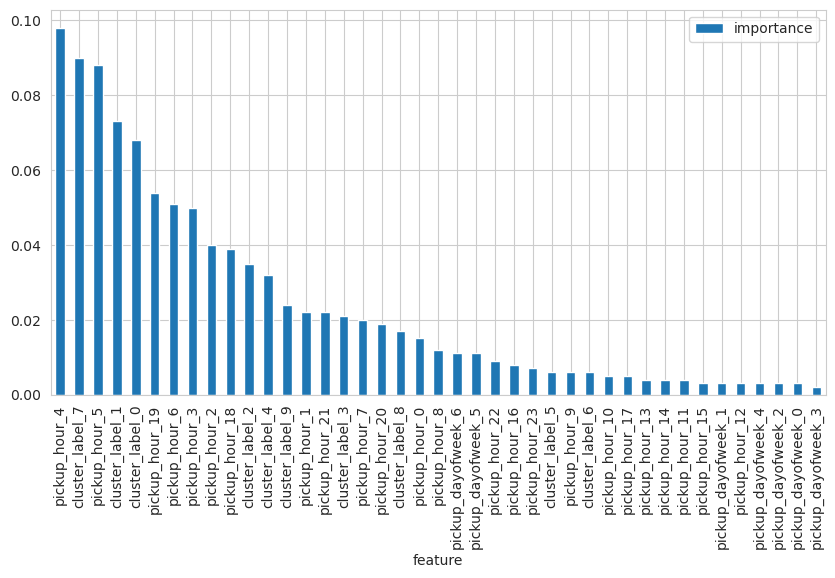

In [35]:
# Training XGboost using hyper parameters selected using grid search CV.

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

params = {"max_depth": 5, "learning_rate": 0.1, "n_estimators": 1000}
model = XGBRegressor(**params)
eval_set = [(X_test_model, y_test_model)]
model.fit(X_train_model , y_train_model, eval_set=eval_set, early_stopping_rounds=10)  # , verbose = True)

prediction_train = model.predict(X_train_model)
mse = mean_squared_error(prediction_train, y_train_model)
r2 = model.score(X_train_model,y_train_model)
print('{}: MSE is {} and R2 is {}'.format('XGBoost on Train', round(mse,2), round(r2,2)))
print('\n')

prediction = model.predict(X_test_model)
mse = mean_squared_error(prediction, y_test_model)
r2 = model.score(X_test_model,y_test_model)
print('{}: MSE is {} and R2 is {}'.format('XGBoost on Test', round(mse,2), round(r2,2)))
print('\n')

importances = pd.DataFrame({'feature':X_train_model.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar(figsize=(10,5))

X_train_model_impfeatures = X_train_model.copy(deep=True) 
X_test_model_impfeatures = X_test_model.copy(deep=True) 

cols_to_remove = ['pickup_dayofweek_0', 'pickup_dayofweek_1', 'pickup_dayofweek_2', 'pickup_dayofweek_3', 'pickup_dayofweek_4', 'pickup_dayofweek_5', 'pickup_dayofweek_6']
X_train_model_impfeatures = X_train_model_impfeatures.drop(cols_to_remove, axis=1)
X_test_model_impfeatures = X_test_model_impfeatures.drop(cols_to_remove, axis=1)

# There is overfitting herein XGboost. Hence, we check feature importance.
# Based on output of feature importance we dropped some features with really low score --> Realised later that Features should be 
##  dropped before encoding rather than After. But, in below graph we also realize that the features related to day of week are all
##  having low importance. Hence drop all the features related to day of week. It will be equivalent to dropping day of week column.


In [37]:
# Training XGboost using hyper parameters selected using grid search CV and using important features only.

params = {"max_depth": 5, "learning_rate": 0.1, "n_estimators": 1000}
model = XGBRegressor(**params)
eval_set = [(X_test_model_impfeatures, y_test_model)]
model.fit(X_train_model_impfeatures , y_train_model, eval_set=eval_set, early_stopping_rounds=10)  # , verbose = True)

prediction_train = model.predict(X_train_model_impfeatures)
mse = mean_squared_error(prediction_train, y_train_model)
r2 = model.score(X_train_model_impfeatures,y_train_model)
print('{}: MSE is {} and R2 is {}'.format('XGBoost on Train', round(mse,2), round(r2,2)))
print('\n')

prediction = model.predict(X_test_model_impfeatures)
mse = mean_squared_error(prediction, y_test_model)
r2 = model.score(X_test_model_impfeatures,y_test_model)
print('{}: MSE is {} and R2 is {}'.format('XGBoost on Test', round(mse,2), round(r2,2)))
print('\n')

# This gives a better result as unimportant features are removed and we do not see overfitting even though we see some drop in metrics

[0]	validation_0-rmse:25.67305
[1]	validation_0-rmse:23.71819
[2]	validation_0-rmse:22.00440
[3]	validation_0-rmse:20.49555
[4]	validation_0-rmse:19.14602
[5]	validation_0-rmse:17.97958
[6]	validation_0-rmse:16.99936
[7]	validation_0-rmse:16.20537
[8]	validation_0-rmse:15.47034
[9]	validation_0-rmse:14.89810
[10]	validation_0-rmse:14.29317
[11]	validation_0-rmse:13.76734
[12]	validation_0-rmse:13.29713
[13]	validation_0-rmse:12.89730
[14]	validation_0-rmse:12.57711
[15]	validation_0-rmse:12.31919
[16]	validation_0-rmse:12.02662
[17]	validation_0-rmse:11.80530
[18]	validation_0-rmse:11.59031
[19]	validation_0-rmse:11.40894
[20]	validation_0-rmse:11.21295
[21]	validation_0-rmse:11.01426
[22]	validation_0-rmse:10.88876


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[23]	validation_0-rmse:10.72180
[24]	validation_0-rmse:10.56091
[25]	validation_0-rmse:10.46503
[26]	validation_0-rmse:10.33854
[27]	validation_0-rmse:10.22384
[28]	validation_0-rmse:10.08784
[29]	validation_0-rmse:10.01076
[30]	validation_0-rmse:9.89541
[31]	validation_0-rmse:9.80768
[32]	validation_0-rmse:9.70537
[33]	validation_0-rmse:9.61599
[34]	validation_0-rmse:9.52666
[35]	validation_0-rmse:9.48216
[36]	validation_0-rmse:9.39573
[37]	validation_0-rmse:9.33594
[38]	validation_0-rmse:9.29094
[39]	validation_0-rmse:9.22920
[40]	validation_0-rmse:9.16258
[41]	validation_0-rmse:9.09630
[42]	validation_0-rmse:9.04360
[43]	validation_0-rmse:9.00678
[44]	validation_0-rmse:8.96108
[45]	validation_0-rmse:8.91013
[46]	validation_0-rmse:8.85610
[47]	validation_0-rmse:8.82613
[48]	validation_0-rmse:8.78567
[49]	validation_0-rmse:8.73383
[50]	validation_0-rmse:8.70766
[51]	validation_0-rmse:8.67453
[52]	validation_0-rmse:8.62805
[53]	validation_0-rmse:8.60937
[54]	validation_0-rmse:8.58347
[

In [38]:
# Hpyerparameter tuning for Random Forest algorithm

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

rf_model = RandomForestRegressor()
param_dist = { 
    'n_estimators': [200, 500, 1000],  # trees in forest
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8]  }
grid_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, cv = 3, 
                                   verbose=1, n_jobs=-1)
grid_search.fit(X_train_model, y_train_model)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
RandomForestRegressor(max_depth=8, max_features='log2', min_samples_split=7,
                      n_estimators=1000)


In [ ]:
## Save the XGBoost model and Kmeans clustering model

In [ ]:
prediction

In [40]:
## Inferences using XGBoost model
# Input will be time of day {0-23} and location cluster. But, we do not get this as input. We have input as datetime column and drop
##  location coordinates. These will be passed as input and we will derive time of day and location cluster using K and then predict
##  demand percentage.

def inferences(pickup_longitude, pickup_latitude, tpep_pickup_datetime):  # model, model_cluster
    df_predict = pd.DataFrame(data= [[pickup_latitude, pickup_longitude]], columns=["pickup_latitude", "pickup_longitude"])
    df_predict['cluster_label'] = kmeans.predict(df_predict)
    
    df_predict.insert(loc = 0, column = 'tpep_pickup_datetime',value = [tpep_pickup_datetime])
    df_predict["tpep_pickup_datetime"] = df_predict["tpep_pickup_datetime"].apply(pd.to_datetime)
    df_predict['pickup_hour'] = df_predict["tpep_pickup_datetime"].dt.hour
    df_predict['pickup_dayofweek'] = df_predict["tpep_pickup_datetime"].dt.dayofweek

    cat_columns = ['pickup_dayofweek', 'pickup_hour', 'cluster_label']
    datastruct_predict_encoded = enc.transform(df_predict[cat_columns]).toarray()
    df_predict_encoded_df = pd.DataFrame(datastruct_predict_encoded, columns=enc.get_feature_names(cat_columns))
    df_predict_model = pd.concat([df_predict.reset_index(), df_predict_encoded_df], axis=1).drop(['index'], axis=1)

    df_predict_model = df_predict_model.drop(cat_columns, axis=1)
    
    # drop additional columner here.
    cols_to_remove = ['pickup_dayofweek_0', 'pickup_dayofweek_1', 'pickup_dayofweek_2', 'pickup_dayofweek_3', 'pickup_dayofweek_4', 'pickup_dayofweek_5', 'pickup_dayofweek_6']
    df_predict_model = df_predict_model.drop(["pickup_latitude", "pickup_longitude" , "tpep_pickup_datetime"], axis=1)
    df_predict_model = df_predict_model.drop(cols_to_remove, axis=1)
    

    df_predict_model[df_predict_model.columns] = df_predict_model[df_predict_model.columns].astype(int)

    # use XGboost with additional features removed.
    prediction = model.predict(df_predict_model)
    prediction = round(prediction[0]*100, 2)
    return prediction
    
print("The demand percentage based on location and time is {}%".format(inferences("40.777981", "-73.980492", "2020-02-13 23:40:00")))

The demand percentage based on location and time is 54.99%


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
